This work is based on **[Kaggle competition](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)**.
<br>
<br>
This is the **modeling (2nd)** part of the project (that consists of 2 notebooks). Key steps that are presented in this part:
1. **Econometric models**
    - Single exponential smoothing (Simple exponential smoothing)
    - Double exponential smoothing (Holt)
    - Triple exponential smoothing (Holt-Winters)
    - SARIMA
2. **Machine Learning models**
    - Ridge
    - Lasso
    - Elastic Net
    - Random Forest
    - k-NN
    - XGBoost
    - LightGBM
3. **Neural Network models**
    - LSTM
4. **Ensembling**
    - 14 models (ML models)
    - 10 models (Some ML models + Holt-Winters)

For most models I will use 2 datasets and compare results, which I receive by submitting predictions to the **Kaggle competition** (**RMSLE** metric is used there).
<br><br>
For econometric models, I use the **full** dataset which contains sales values for all dates (missing values on December 25 and 0 values on January 1 were filled with linear combinations of lagged sales values) and the **cleaned** dataset which contains sales values, but missing values and values on days when stores weren't working were removed from it.
<br><br>
As for ML and NN models, I use the **without lags** and the **with lags** datasets. In the first case, missing missing values and values on days when stores weren't working were removed from dataset. The second one is same as the first one, but where lagged sales values with different lags and window were injected additionally.
<br><br>
Each previously mentioned dataset consists of **1686** smaller datasets containing data, each associated with a unique pair of **store number** and **family**. These smaller datasets will be referred to as **sub datasets** further in this notebook. Models will be trained independently for each such **sub dataset**. This will move existing into time series domain, so appropriate methods and models can be used to solve it.
<br><br>
Other **96** (54 unique stores * 33 unique families - 1686 = 1782 - 1686 = 96) pairs of **store number** and **family** were determined to not match (such product families weren't sold at according store at least 1 time during last 2 months of the training period) in the 1st part of the project, therefore for such combinations I'll just leave 0 as prediction for every day of the testing period.
<br><br>
All the data preprocessing took place in the previous part of the project (**EDA**).

# Libraries and data loading

In [ ]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_log_error as rmsle

import optuna

In [ ]:
unique_sf = pd.read_csv('preprocessed_datasets/unique_sf.csv').values

In [ ]:
test_index = pd.read_csv('initial_datasets/test.csv', index_col=0).index

In [ ]:
train_initial_dict = dict()

train_base_dict = dict()
test_base_dict = dict()

train_with_lags_dict = dict()
test_with_lags_dict = dict()

for s, f in unique_sf:
    train_initial_dict[(s, f)] = pd.read_csv(f'preprocessed_datasets/train_initial/s_{s}_f_{f.lower().replace("/", "_or_")}_train_initial.csv')['sales']
    
    train_base_dict[(s, f)] = pd.read_csv(f'preprocessed_datasets/train_base/s_{s}_f_{f.lower().replace("/", "_or_")}_train_base.csv', index_col=0, parse_dates=['date'])
    test_base_dict[(s, f)] = pd.read_csv(f'preprocessed_datasets/test_base/s_{s}_f_{f.lower().replace("/", "_or_")}_test_base.csv', index_col=0, parse_dates=['date'])

    train_with_lags_dict[(s, f)] = pd.read_csv(f'preprocessed_datasets/train_with_lags/s_{s}_f_{f.lower().replace("/", "_or_")}_train_with_lags.csv', index_col=0, parse_dates=['date'])
    test_with_lags_dict[(s, f)] = pd.read_csv(f'preprocessed_datasets/test_with_lags/s_{s}_f_{f.lower().replace("/", "_or_")}_test_with_lags.csv', index_col=0, parse_dates=['date'])

In [ ]:
if not os.path.exists(f'predictions'):
    os.makedirs(f'predictions')

if not os.path.exists(f'model_hyperparameters'):
    os.makedirs(f'model_hyperparameters')

In [ ]:
def make_datasets(dataset, s, f):
    if dataset == 'full':
        values = train_initial_dict[(s, f)].values
        return values
    elif dataset == 'cleaned':
        values = train_base_dict[(s, f)]['sales'].values
        return values
    elif dataset == 'without_lags':
        train = train_base_dict[(s, f)]
        
        X_train = train.drop(columns=['date', 'store_nbr', 'family', 'sales'])
        y_train = train['sales']

        X_test = test_base_dict[(s, f)].drop(columns=['date', 'store_nbr', 'family'])
        return X_train, y_train, X_test
    elif dataset == 'with_lags':
        train = train_with_lags_dict[(s, f)]
        
        X_train = train.drop(columns=['date', 'store_nbr', 'family', 'sales'])
        y_train = train['sales']
        
        X_test = test_with_lags_dict[(s, f)].drop(columns=['date', 'store_nbr', 'family'])
        return X_train, y_train, X_test


def save_params(params, model_name, dataset, path):
    if not os.path.exists(f'model_hyperparameters/{model_name}_params/{dataset}'):
        os.makedirs(f'model_hyperparameters/{model_name}_params/{dataset}')
    params.to_csv(path, index_label='parameter', header=['value'])

# Econometric models

## Simple (single) exponential smoothing

It's the simplest form of exponential smoothing. It assumes that there is no **trend** and no **seasonality** in data. To remove trend I computed consecutive differences and used these values for predicting.

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

def exp_smoothing_forecasting(values, diff_values, preds, preds_index, forecasting_period):
    model = SimpleExpSmoothing(diff_values)
    model = model.fit(optimized=True)

    predicted_diff = model.forecast(forecasting_period)
    predicted_values = pd.Series(np.insert(predicted_diff, 0, values[-1])).expanding(1).sum()[1:]
    
    preds[preds_index] = predicted_values    

### Full dataset

In [ ]:
dataset = 'full'

preds_exp_smoothing_full = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    preds_index = test_base_dict[(s, f)].index
    
    values = make_datasets(dataset, s, f)
        
    diff_values = values[1:] - values[:-1]
    
    exp_smoothing_forecasting(values, diff_values, preds_exp_smoothing_full, preds_index, 16)

In [ ]:
preds_exp_smoothing_full.index = test_index
preds_exp_smoothing_full.to_csv('predictions/exp_smoothing_full_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.60248**

### Cleaned dataset

In [ ]:
dataset = 'cleaned'

preds_exp_smoothing_cleaned = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    preds_index = test_base_dict[(s, f)].index
    
    values = make_datasets(dataset, s, f)
        
    diff_values = values[1:] - values[:-1]
    
    exp_smoothing_forecasting(values, diff_values, preds_exp_smoothing_cleaned, preds_index, 16)

In [ ]:
preds_exp_smoothing_cleaned.index = test_index
preds_exp_smoothing_cleaned.to_csv('predictions/exp_smoothing_cleaned_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.60494**

## Holt (Double exponential smoothing)

This model assumes that **trend** exists but there is still no **seasonality** in data.

In [ ]:
from statsmodels.tsa.holtwinters import Holt

def holt_forecasting(values, preds, preds_index, forecasting_period):
    model = Holt(values)
    model = model.fit(optimized=True)

    predicted = model.forecast(forecasting_period)
    
    preds[preds_index] = predicted

### Full dataset

In [ ]:
dataset = 'full'

preds_holt_full = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    preds_index = test_base_dict[(s, f)].index

    values = make_datasets(dataset, s, f)
    
    holt_forecasting(values, preds_holt_full, preds_index, 16)

In [ ]:
preds_holt_full.index = test_index
preds_holt_full.to_csv('predictions/holt_full_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.54739**

### Cleaned dataset

In [ ]:
dataset = 'cleaned'

preds_holt_cleaned = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    preds_index = test_base_dict[(s, f)].index

    values = make_datasets(dataset, s, f)

    holt_forecasting(values, preds_holt_cleaned, preds_index, 16)

In [ ]:
preds_holt_cleaned.index = test_index
preds_holt_cleaned.to_csv('predictions/holt_cleaned_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.53329**

**Holt model** is clearly an improvement over **Single Exponential Smoothing**!

## Holt-Winters (Triple exponential smoothing)

This model assumes that both **trend** and **seasonality** are presented in data.

Seasonality is not completely the same and not stable for every dataset. But I'll go with **7** (days) as seasonality period (weekly cycles), because I believe that's the most universal choice.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def holt_winters_forecasting(values, preds, preds_index, forecasting_period):      
    model = ExponentialSmoothing(values, trend='add', seasonal='add', seasonal_periods=7)
    model = model.fit(optimized=True)

    predicted = np.maximum(model.forecast(forecasting_period), 0)
    
    preds[preds_index] = predicted

### Full dataset

In [ ]:
%%time

dataset = 'full'

preds_holt_winters_full = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    preds_index = test_base_dict[(s, f)].index

    values = make_datasets(dataset, s, f)
    
    holt_winters_forecasting(values, preds_holt_winters_full, preds_index, 16)

In [ ]:
preds_holt_winters_full.index = test_index
preds_holt_winters_full.to_csv('predictions/holt_winters_full_preds_2.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.43131**

### Cleaned dataset

In [ ]:
%%time

dataset = 'cleaned'

preds_holt_winters_cleaned = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    preds_index = test_base_dict[(s, f)].index
    
    values = make_datasets(dataset, s, f)
    
    holt_winters_forecasting(values, preds_holt_winters_cleaned, preds_index, 16)

In [ ]:
preds_holt_winters_cleaned.index = test_index
preds_holt_winters_cleaned.to_csv('predictions/holt_winters_cleaned_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.43517**

**Holt-Winters model** demonstrates really good results and is also a huge improvement over both **Single Exponential Smoothing** and **Holt model**!

## SARIMA

**SARIMA model** is an extension of the ARIMA model that includes support for seasonality. It combines autoregression (AR or p), differencing (I or d) and moving average (MA or q), along with seasonal components (P, D, Q).

In [ ]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA


def find_arima_params(values, dataset, path):          
    model = auto_arima(values, m=7, stepwise=True, error_action='ignore', suppress_warnings=True, method='nm')
    print(model.summary())
        
    params = np.hstack([np.array(model.order), np.array(model.seasonal_order)])
    params = pd.Series(params, index=['p', 'd', 'q', 'P', 'D', 'Q', 'm'])
        
    save_params(params, 'arima', dataset, path)


def arima_forecasting(values, path, preds, preds_index, forecasting_period):
    params = pd.read_csv(path, index_col=0)
    
    model = ARIMA(order=params[:3].values, seasonal_order=params[3:].values, method='nm')
    model.fit(values)

    predicted = np.maximum(model.predict(forecasting_period), 0)

    preds[preds_index] = predicted

### Full dataset

In [ ]:
rewrite = False
dataset = 'full'

for s, f in unique_sf:
    path = f'model_hyperparameters/arima_params/{dataset}/arima_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        values = make_datasets(dataset, s, f)
        
        find_arima_params(values, dataset, path)

In [ ]:
dataset = 'full'

preds_arima_full = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/arima_params/{dataset}/arima_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    preds_index = test_base_dict[(s, f)].index

    values = make_datasets(dataset, s, f)
    
    arima_forecasting(values, path, preds_arima_full, preds_index, 16)

In [ ]:
preds_arima_full.index = test_index
preds_arima_full.to_csv('predictions/arima_full_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.50377**

### Cleaned dataset

In [ ]:
%%time

rewrite = False
dataset = 'cleaned'

for s, f in unique_sf:
    path = f'model_hyperparameters/arima_params/{dataset}/arima_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        values = make_datasets(dataset, s, f)
        
        find_arima_params(values, dataset, path)

In [ ]:
dataset = 'cleaned'

preds_arima_cleaned = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/arima_params/{dataset}/arima_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    preds_index = test_base_dict[(s, f)].index

    values = make_datasets(dataset, s, f)
    
    arima_forecasting(values, path, preds_arima_cleaned, preds_index, 16)

In [ ]:
preds_arima_cleaned.index = test_index
preds_arima_cleaned.to_csv('predictions/arima_cleaned_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.52171**

# Machine Learning models

With time series data it's crucial to use **Time Series Cross-Validation scheme** (*TimeSeriesSplit* and not *KFold*) for optimization of hyperparameters. More info **[here](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4)**.

## Feature importances

Let's check what features are more important and what are less. I'll use built-in **feature_importances_** atribute in sklearn's **Random Forest model**.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def find_feature_importances(s, f):
    train = train_with_lags_dict[(s, f)]
    
    X_train = train.drop(columns=['date', 'store_nbr', 'family', 'sales'])
    y_train = train['sales']
    
    model = RandomForestRegressor(n_estimators=50, random_state=92)
    model = model.fit(X_train, y_train)
    
    feature_importances.loc[X_train.columns, 'importances_sum'] += model.feature_importances_
    feature_importances.loc[X_train.columns, 'count'] += 1

In [ ]:
# cols = train_with_lags_dict[(1, 'Automotive')].drop(columns=['date', 'store_nbr', 'family', 'sales']).columns

# feature_importances = pd.DataFrame(np.zeros(shape=(len(cols), 2)), index=cols, columns=['importances_sum', 'count'])

# for s, f in unique_sf:
#     find_feature_importances(s, f)

In [ ]:
# feature_importances['importance'] = (feature_importances['importances_sum'] / feature_importances['count'])
# feature_importances['importance'].sort_values(ascending=False).to_csv('preprocessed_datasets/feature_importances.csv')

In [ ]:
feature_importances = pd.read_csv('preprocessed_datasets/feature_importances.csv', index_col=0)
feature_importances

As you can see, **time related**, **lag**, **onpromotion** and **oil_price** features are pretty important. Meanwhile I can't say so for **holiday** features, as any of these are ranked lower than any of previously mentioned.

## Ridge regression

**Ridge regression** is a type of **linear regression** that adds a penalty (**L2 regularization**) to the size of the coefficients to prevent overfitting.

<div style="text-align: center;">
    <img src="https://images.deepai.org/glossary-terms/d154adc4d9cd44849c10592a521f379d/ridge.png" 
        alt="Ridge" style="width: 500px; height: auto;">
</div>

Image source: https://deepai.org/

In [ ]:
from sklearn.linear_model import Ridge

def ridge_objective(trial):
    time_series_cv = TimeSeriesSplit(n_splits=3)
    params = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e5, log=True) 
    }

    scaler = trial.suggest_categorical('scaler', ['minmax', 'robust', 'standard'])

    if scaler == 'minmax':
        scaler = MinMaxScaler()
    elif scaler == 'robust':
        scaler = RobustScaler()
    else:
        scaler = StandardScaler()

    model = Pipeline([
        ('scaler', scaler),
        ('ridge', Ridge(**params))
    ])
    
    score = cross_val_score(model, X_train, y_train, cv=time_series_cv, scoring='neg_root_mean_squared_error', n_jobs=8).mean()
    return score


def ridge_forecasting(X_train, y_train, X_test, path, preds, preds_index):
    params = pd.read_csv(path, index_col=0)
    params = params.iloc[:, 0].to_dict()

    scaler = params['scaler']

    if scaler == 'robust':
        scaler = RobustScaler()
    elif scaler == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
        
    del params['scaler']

    for i in params:
        params[i] = float(params[i])


    model = Pipeline([
        ('scaler', scaler),
        ('ridge', Ridge(**params))
    ])

    model.fit(X_train, y_train)

    predicted = np.maximum(model.predict(X_test), 0)

    preds[preds_index] = predicted

### Dataset without lags

In [ ]:
rewrite = False
dataset = 'without_lags'

optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/ridge_params/{dataset}/ridge_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        X_train, y_train, _ = make_datasets(dataset, s, f)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(ridge_objective, n_trials=300, n_jobs=8)

        best_params = pd.Series(study.best_params)
        print(best_params, study.best_value)

        save_params(params, 'ridge', dataset, path)

In [ ]:
dataset = 'without_lags'

preds_ridge_without_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/ridge_params/{dataset}/ridge_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'

    X_train, y_train, X_test = make_datasets(dataset, s, f)
    
    preds_index = test_base_dict[(s, f)].index
    
    ridge_forecasting(X_train, y_train, X_test, path, preds_ridge_without_lags, preds_index)

In [ ]:
preds_ridge_without_lags.index = test_index
preds_ridge_without_lags.to_csv('predictions/ridge_without_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.48332**

### Dataset with lags

In [ ]:
rewrite = False
dataset = 'with_lags'

optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/ridge_params/{dataset}/ridge_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        X_train, y_train, _ = make_datasets(dataset, s, f)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(ridge_objective, n_trials=400, n_jobs=8)

        best_params = pd.Series(study.best_params)
        print(best_params, study.best_value)

        save_params(params, 'ridge', dataset, path)

In [ ]:
dataset = 'with_lags'

preds_ridge_with_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/ridge_params/{dataset}/ridge_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'

    X_train, y_train, X_test = make_datasets(dataset, s, f)
    
    preds_index = test_base_dict[(s, f)].index
    
    ridge_forecasting(X_train, y_train, X_test, path, preds_ridge_with_lags, preds_index)

In [ ]:
preds_ridge_with_lags.index = test_index
preds_ridge_with_lags.to_csv('predictions/ridge_with_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.45105**

## Lasso regression

**Lasso regression** is a type of **linear regression** that adds a penalty (**L1 regularization**) to the size of the coefficients to prevent overfitting.

<div style="text-align: center;">
    <img src="https://cdn.corporatefinanceinstitute.com/assets/lasso.png" 
        alt="Lasso" style="width: 500px; height: auto;">
</div>

Image source: https://corporatefinanceinstitute.com

In [ ]:
from sklearn.linear_model import Lasso

def lasso_objective(trial):
    time_series_cv = TimeSeriesSplit(n_splits=3)
    params = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e5, log=True) 
    }

    scaler = trial.suggest_categorical('scaler', ['minmax', 'robust', 'standard'])

    if scaler == 'minmax':
        scaler = MinMaxScaler()
    elif scaler == 'robust':
        scaler = RobustScaler()
    else:
        scaler = StandardScaler()
    
    model = Pipeline([
        ('scaler', scaler),
        ('lasso', Lasso(**params))
    ])
    
    score = cross_val_score(model, X_train, y_train, cv=time_series_cv, scoring='neg_root_mean_squared_error', n_jobs=8).mean()
    return score


def lasso_forecasting(X_train, y_train, X_test, path, preds, preds_index):
    params = pd.read_csv(path, index_col=0)
    params = params.iloc[:, 0].to_dict()

    scaler = params['scaler']

    if scaler == 'robust':
        scaler = RobustScaler()
    elif scaler == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
        
    del params['scaler']
    
    for i in params:
        params[i] = float(params[i])
    
    model = Pipeline([
        ('scaler', scaler),
        ('lasso', Lasso(**params))
    ])
    
    model.fit(X_train, y_train)

    predicted = np.maximum(model.predict(X_test), 0)

    preds[preds_index] = predicted

### Dataset without lags

In [ ]:
rewrite = False
dataset = 'without_lags'

optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/lasso_params/{dataset}/lasso_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        X_train, y_train, _ = make_datasets(dataset, s, f)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(lasso_objective, n_trials=250, n_jobs=8)

        best_params = pd.Series(study.best_params)
        print(best_params, study.best_value)

        save_params(params, 'lasso', dataset, path)

In [ ]:
dataset = 'without_lags'

preds_lasso_without_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/lasso_params/{dataset}/lasso_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'

    X_train, y_train, X_test = make_datasets(dataset, s, f)
    
    preds_index = test_base_dict[(s, f)].index

    lasso_forecasting(X_train, y_train, X_test, path, preds_lasso_without_lags, preds_index)

In [ ]:
preds_lasso_without_lags.index = test_index
preds_lasso_without_lags.to_csv('predictions/lasso_without_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.48306**

### Dataset with lags

In [ ]:
rewrite = False
dataset = 'with_lags'

optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/lasso_params/{dataset}/lasso_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        X_train, y_train, _ = make_datasets(dataset, s, f)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(lasso_objective, n_trials=200, n_jobs=8)

        best_params = pd.Series(study.best_params)
        print(best_params, study.best_value)

        save_params(params, 'lasso', dataset, path)

In [ ]:
dataset = 'with_lags'

preds_lasso_with_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/lasso_params/{dataset}/lasso_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'

    X_train, y_train, X_test = make_datasets(dataset, s, f)
    
    preds_index = test_base_dict[(s, f)].index

    lasso_forecasting(X_train, y_train, X_test, path, preds_lasso_with_lags, preds_index)

In [ ]:
preds_lasso_with_lags.index = test_index
preds_lasso_with_lags.to_csv('predictions/lasso_with_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.46490**

## Elastic Net

**Elastic Net regression** is a type of **linear regression** that adds a pair penalties (**L1 + L2 regularization**) to the size of the coefficients to prevent overfitting.

<div style="text-align: center;">
    <img src="https://drek4537l1klr.cloudfront.net/rhys/v-4/Figures/CH09_FIG_9_MLR.png" 
        alt="Elastic Net" style="width: 500px; height: auto;">
</div>

Image source: https://analyticsindiamag.com/

In [ ]:
from sklearn.linear_model import ElasticNet

def elastic_net_objective(trial):
    time_series_cv = TimeSeriesSplit(n_splits=3)
    params = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e5, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1)
    }

    scaler = trial.suggest_categorical('scaler', ['minmax', 'robust', 'standard'])

    if scaler == 'minmax':
        scaler = MinMaxScaler()
    elif scaler == 'robust':
        scaler = RobustScaler()
    else:
        scaler = StandardScaler()
    
    model = Pipeline([
        ('scaler', scaler),
        ('elastic_net', ElasticNet(**params))
    ])
    
    score = cross_val_score(model, X_train, y_train, cv=time_series_cv, scoring='neg_root_mean_squared_error', n_jobs=8).mean()
    return score


def elastic_net_forecasting(X_train, y_train, X_test, path, preds, preds_index):
    params = pd.read_csv(path, index_col=0)
    params = params.iloc[:, 0].to_dict()

    scaler = params['scaler']

    if scaler == 'robust':
        scaler = RobustScaler()
    elif scaler == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
        
    del params['scaler']
    
    for i in params:
        params[i] = float(params[i])
  
    model = Pipeline([
        ('scaler', scaler),
        ('elastic_net', ElasticNet(**params))
    ])
    model.fit(X_train, y_train)

    predicted = np.maximum(model.predict(X_test), 0)

    preds[preds_index] = predicted

### Dataset without lags

In [ ]:
rewrite = False
dataset = 'without_lags'

optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/elastic_net_params/{dataset}/elastic_net_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        X_train, y_train, _ = make_datasets(dataset, s, f)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(elastic_net_objective, n_trials=200, n_jobs=8)

        best_params = pd.Series(study.best_params)
        print(best_params, study.best_value)

        save_params(params, 'elastic_net', dataset, path)

In [ ]:
%%time

dataset = 'without_lags'

preds_elastic_net_without_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/elastic_net_params/{dataset}/elastic_net_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'

    X_train, y_train, X_test = make_datasets(dataset, s, f)
    
    preds_index = test_base_dict[(s, f)].index

    elastic_net_forecasting(X_train, y_train, X_test, path, preds_elastic_net_without_lags, preds_index)

In [ ]:
preds_elastic_net_without_lags.index = test_index
preds_elastic_net_without_lags.to_csv('predictions/elastic_net_without_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.48005**

### Dataset with lags

In [ ]:
rewrite = False
dataset = 'with_lags'

optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/elastic_net_params/{dataset}/elastic_net_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        X_train, y_train, _ = make_datasets(dataset, s, f)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(elastic_net_objective, n_trials=200, n_jobs=8)

        best_params = pd.Series(study.best_params)
        print(best_params, study.best_value)

        save_params(params, 'elastic_net', dataset, path)

In [ ]:
%%time

dataset = 'with_lags'

preds_elastic_net_with_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/elastic_net_params/{dataset}/elastic_net_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'

    X_train, y_train, X_test = make_datasets(dataset, s, f)
    
    preds_index = test_base_dict[(s, f)].index

    elastic_net_forecasting(X_train, y_train, X_test, path, preds_elastic_net_with_lags, preds_index)

In [ ]:
preds_elastic_net_with_lags.index = test_index
preds_elastic_net_with_lags.to_csv('predictions/elastic_net_with_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.46420**

All 3 linear models provide similar results, but **Ridge** turns out to be the best for this data.

Dataset **with lags** tends to perform better with linear models.

## Random Forest

**Random Forest** is an *ensemble* learning method that uses multiple decision trees to predict continuous values (if it is regression task). It averages the predictions from many trees to improve accuracy and reduce overfitting.

<div style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:1010/1*R3oJiyaQwyLUyLZL-scDpw.png" 
        alt="Random Forest" style="width: 500px; height: auto;">
</div>

Image source: https://medium.com/@denizgunay/random-forest-af5bde5d7e1e

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def rf_objective(trial):
    time_series_cv = TimeSeriesSplit(n_splits=3)
    params = {
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 150),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 151),
        'max_features': trial.suggest_float('max_features', 0.2, 1.0),
        'max_depth': trial.suggest_int('max_depth', 2, 25)
    }

    model = RandomForestRegressor(**params, n_estimators=100, random_state=92, n_jobs=5)
        
    score = cross_val_score(model, X_train, y_train, cv=time_series_cv, scoring='neg_root_mean_squared_log_error', n_jobs=4).mean()
    return score


def rf_forecasting(X_train, y_train, X_test, path, preds, preds_index):
    params = pd.read_csv(path, index_col=0)
    params = params.iloc[:, 0].to_dict()
    
    for i in params:
        if int(params[i]) == params[i]:
            params[i] = int(params[i])
    
    model = RandomForestRegressor(**params, n_estimators=500, random_state=92, n_jobs=8)
    model.fit(X_train, y_train)

    predicted = np.maximum(model.predict(X_test), 0)

    preds[preds_index] = predicted

### Dataset without lags

In [ ]:
rewrite = False
dataset = 'without_lags'

optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/rf_params/{dataset}/rf_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        X_train, y_train, _ = make_datasets(dataset, s, f)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(rf_objective, n_trials=300)

        best_params = pd.Series(study.best_params)
        print(best_params, study.best_value)

        save_params(params, 'rf', dataset, path)

In [ ]:
%%time

dataset = 'without_lags'

preds_rf_without_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/rf_params/{dataset}/rf_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'

    X_train, y_train, X_test = make_datasets(dataset, s, f)
    
    preds_index = test_base_dict[(s, f)].index
    
    rf_forecasting(X_train, y_train, X_test, path, preds_rf_without_lags, preds_index)

In [ ]:
preds_rf_without_lags.index = test_index
preds_rf_without_lags.to_csv('predictions/rf_without_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.42014**

### Dataset with lags

In [ ]:
rewrite = False
dataset = 'with_lags'

optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/rf_params/{dataset}/rf_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        X_train, y_train, _ = make_datasets(dataset, s, f)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(rf_objective, n_trials=200, n_jobs=8)

        best_params = pd.Series(study.best_params)
        print(best_params, study.best_value)

        save_params(params, 'rf', dataset, path)

In [ ]:
%%time

dataset = 'with_lags'

preds_rf_with_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/rf_params/{dataset}/rf_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'

    X_train, y_train, X_test = make_datasets(dataset, s, f)
    
    preds_index = test_base_dict[(s, f)].index
    
    rf_forecasting(X_train, y_train, X_test, path, preds_rf_with_lags, preds_index)

In [ ]:
preds_rf_with_lags.index = test_index
preds_rf_with_lags.to_csv('predictions/rf_with_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.44696**

**Random Forest** shows great results. Especially this is true for dataset **without lags**, which scored **0.42014 RMSLE loss**.

## k-NN

**K-Nearest Neighbors (k-NN) model** predicts the value of a data point based on the average (*might be weighted*) of the values of its k nearest neighbors. It uses the distance (*might be Manhattan, Euclidean or other*) between points to find the closest neighbors in the dataset.


<div style="text-align: center;">
    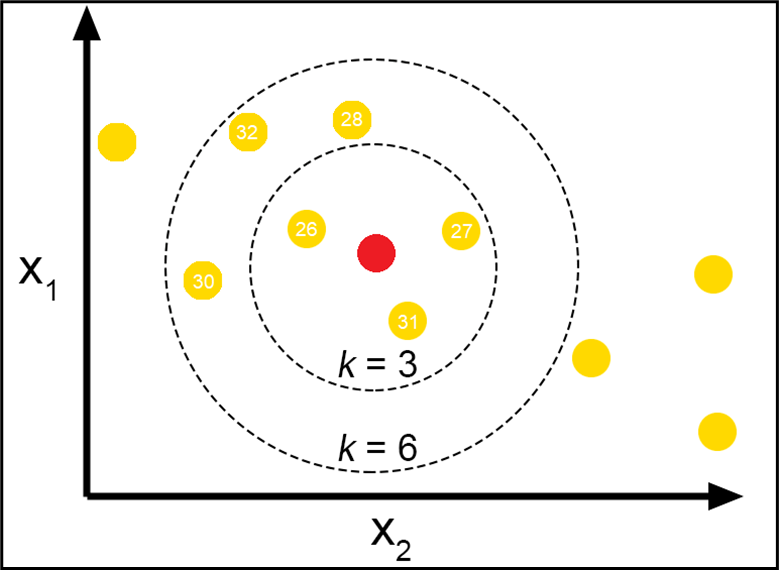
</div>

Image source: https://towardsdatascience.com/knn-k-nearest-neighbors-1-a4707b24bd1d
<br>
Modified by me

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def knn_objective(trial):
    time_series_cv = TimeSeriesSplit(n_splits=3)

    max_neighbors = int(X_train.shape[0] / 5) - 1
    
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, max_neighbors),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2),
    }

    scaler = trial.suggest_categorical('scaler', ['minmax', 'robust', 'standard'])

    if scaler == 'minmax':
        scaler = MinMaxScaler()
    elif scaler == 'robust':
        scaler = RobustScaler()
    else:
        scaler = StandardScaler()
    
    model = Pipeline([
        ('scaler', scaler),
        ('knn', KNeighborsRegressor(**params, n_jobs=8))
    ])
        
    score = cross_val_score(model, X_train, y_train, cv=time_series_cv, scoring='neg_root_mean_squared_log_error', n_jobs=8).mean()
    return score


def knn_forecasting(X_train, y_train, X_test, path, preds, preds_index):
    params = pd.read_csv(path, index_col=0)
    params = params.iloc[:, 0].to_dict()

    scaler = params['scaler']

    if scaler == 'robust':
        scaler = RobustScaler()
    elif scaler == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
        
    del params['scaler']
    
    for i in params:
        if params[i].isdigit() and int(params[i]) == float(params[i]):
            params[i] = int(params[i])
    
    model = Pipeline([
        ('scaler', scaler),
        ('knn', KNeighborsRegressor(**params, n_jobs=8))
    ])
    
    model.fit(X_train, y_train)

    predicted = np.maximum(model.predict(X_test), 0)

    preds[preds_index] = predicted

### Dataset without lags

In [ ]:
rewrite = True
dataset = 'without_lags'

optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/knn_params/{dataset}/knn_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        X_train, y_train, _ = make_datasets(dataset, s, f)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(knn_objective, n_trials=250, n_jobs=8)

        best_params = pd.Series(study.best_params)
        print(best_params, study.best_value)

        save_params(params, 'knn', dataset, path)

In [ ]:
%%time

dataset = 'without_lags'

preds_knn_without_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/knn_params/{dataset}/knn_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'

    X_train, y_train, X_test = make_datasets(dataset, s, f)
    
    preds_index = test_base_dict[(s, f)].index

    knn_forecasting(X_train, y_train, X_test, path, preds_knn_without_lags, preds_index)

In [ ]:
preds_knn_without_lags.index = test_index
preds_knn_without_lags.to_csv('predictions/knn_without_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.43843**

### Dataset with lags

In [ ]:
rewrite = False
dataset = 'with_lags'

optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/knn_params/{dataset}/knn_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        X_train, y_train, _ = make_datasets(dataset, s, f)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(knn_objective, n_trials=250, n_jobs=8)

        best_params = pd.Series(study.best_params)
        print(best_params, study.best_value)

        save_params(params, 'knn', dataset, path)

In [ ]:
%%time

dataset = 'with_lags'

preds_knn_with_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/knn_params/{dataset}/knn_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'

    X_train, y_train, X_test = make_datasets(dataset, s, f)
    
    preds_index = test_base_dict[(s, f)].index

    knn_forecasting(X_train, y_train, X_test, path, preds_knn_with_lags, preds_index)

In [ ]:
preds_knn_with_lags.index = test_index
preds_knn_with_lags.to_csv('predictions/knn_with_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.43540**

**k-NN** results are good. Dataset **with lags** takes a little advantage here.

## XGBoost

**Gradient Boosting** is a machine learning technique that builds an ensemble of weak models (usually **decision trees**) sequentially. Each new model corrects the errors of the previous ones by minimizing a loss function, improving prediction accuracy over time.

<div style="text-align: center;">
    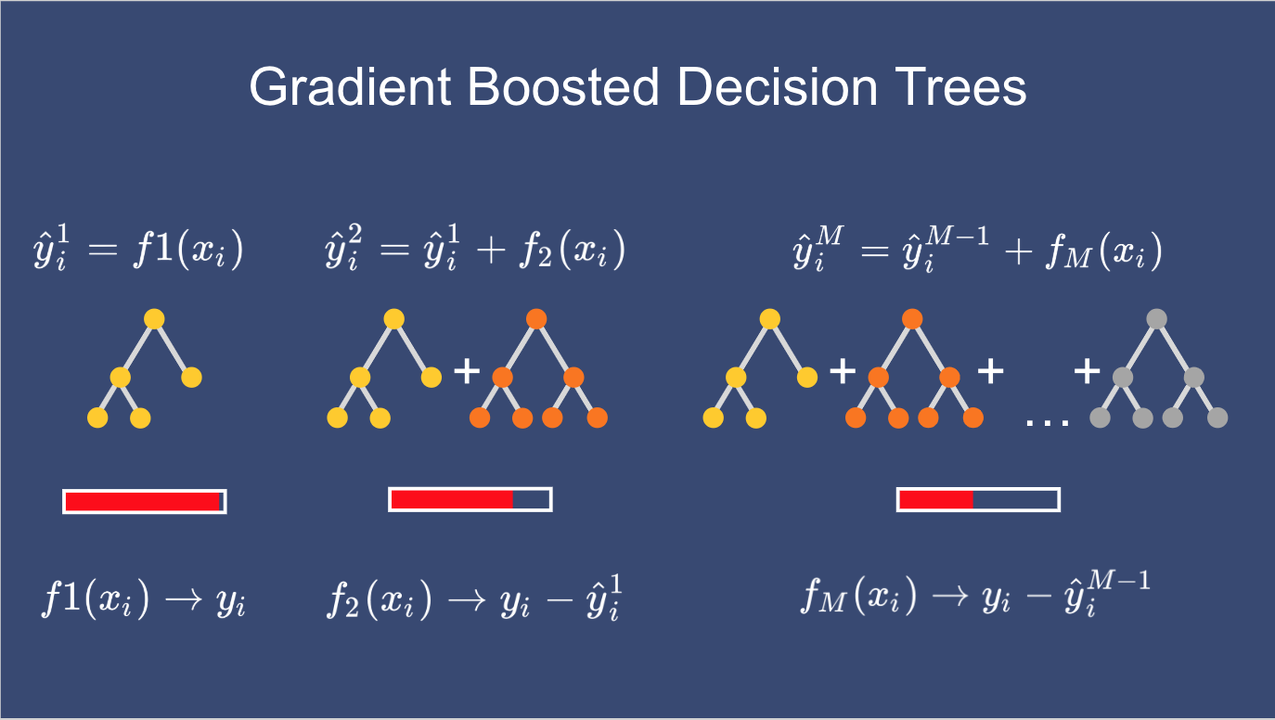
</div>

Image source: https://www.linkedin.com/pulse/mastering-gradient-boosting-machine-learning-guide-pratik-thorat


**XGBoost** is a model that uses **gradient boosting** and enhances it with some features (regularization, higher training efficiency, more tree hyperparameters etc.)


<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/6/69/XGBoost_logo.png" 
        alt="XGBoost" style="width: 500px; height: auto;">
</div>

Image source: https://uk.wikipedia.org/wiki/XGBoost

In [ ]:
from xgboost import XGBRegressor

def xgb_objective(trial):
    time_series_cv = TimeSeriesSplit(n_splits=3)
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 100),
        'learning_rate': trial.suggest_float('learning_rate', 2e-3, 0.5, log=True)
    }
    
    model = XGBRegressor(**params, n_estimators=n_estimators, random_state=92)
    
    score = cross_val_score(model, X_train, y_train, cv=time_series_cv, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
    return score


def xgb_forecasting(X_train, y_train, X_test, path, preds, preds_index):
    params = pd.read_csv(path, index_col=0)
    params = params.iloc[:, 0].to_dict()

    for i in params:
        if int(params[i]) == params[i]:
            params[i] = int(params[i])

    model = XGBRegressor(**params, random_state=92, n_jobs=8)

    model.fit(X_train, y_train)

    predicted = np.maximum(model.predict(X_test), 0)

    preds[preds_index] = predicted

### Dataset without lags

In [ ]:
rewrite = False
dataset = 'without_lags'
n_estimators = 200

optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/xgb_params/{dataset}/xgb_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        X_train, y_train, _ = make_datasets(dataset, s, f)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(xgb_objective, n_trials=400)

        best_params = study.best_params
        best_params['n_estimators'] = n_estimators
        best_params = pd.Series(best_params)
        
        print(best_params, study.best_value)

        save_params(params, 'xgb', dataset, path)

In [ ]:
%%time

dataset = 'without_lags'

preds_xgb_without_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/xgb_params/{dataset}/xgb_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'

    X_train, y_train, X_test = make_datasets(dataset, s, f)
    
    preds_index = test_base_dict[(s, f)].index
    
    xgb_forecasting(X_train, y_train, X_test, path, preds_xgb_without_lags, preds_index)

In [ ]:
preds_xgb_without_lags.index = test_index
preds_xgb_without_lags.to_csv('predictions/xgb_without_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.43196**

### Dataset with lags

In [ ]:
rewrite = False
dataset = 'with_lags'
n_estimators = 200

optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/xgb_params/{dataset}/xgb_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        X_train, y_train, _ = make_datasets(dataset, s, f)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(xgb_objective, n_trials=400)

        best_params = study.best_params
        best_params['n_estimators'] = n_estimators
        best_params = pd.Series(best_params)

        print(best_params, study.best_value)

        save_params(params, 'xgb', dataset, path)

In [ ]:
%%time

dataset = 'with_lags'

preds_xgb_with_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/xgb_params/{dataset}/xgb_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'

    X_train, y_train, X_test = make_datasets(dataset, s, f)
    
    preds_index = test_base_dict[(s, f)].index
    
    xgb_forecasting(X_train, y_train, X_test, path, preds_xgb_with_lags, preds_index)

In [ ]:
preds_xgb_with_lags.index = test_index
preds_xgb_with_lags.to_csv('predictions/xgb_with_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.43716**

**XGBoost's** performance is a little bit better than **k-NN's**. Dataset **without lags** excels here with **0.43196 loss**.

## LightGBM

**LightGBM**, like **XGBoost**, uses gradient boosting technique and improves it with new features (leaf-wise tree growth, parallel computing, more tree hyperparameters etc.)

<div style="text-align: center;">
    <img src="https://lightgbm.readthedocs.io/en/latest/_images/LightGBM_logo_black_text.svg" 
        alt="LightGBM" style="width: 500px; height: auto;">
</div>

Image source: https://lightgbm.readthedocs.io/

In [ ]:
from lightgbm import LGBMRegressor

def lgbm_objective(trial):
    time_series_cv = TimeSeriesSplit(n_splits=3)
    
    params = {
    'num_leaves': trial.suggest_int('num_leaves', 2, 31),
    'max_depth': trial.suggest_int('max_depth', 2, 7),
    'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10, log=True),
    'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10, log=True),
    'subsample': trial.suggest_float('subsample', 0.25, 1.0),
    'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 1.0),
    'learning_rate': trial.suggest_float('learning_rate', 2e-3, 0.5, log=True)
    }
    
    model = LGBMRegressor(**params, n_estimators=n_estimators, random_state=92, n_jobs=1)
    
    score = cross_val_score(model, X_train, y_train, cv=time_series_cv, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
    return score


def lgbm_forecasting(X_train, y_train, X_test, path, preds, preds_index):
    params = pd.read_csv(path, index_col=0)
    params = params.iloc[:, 0].to_dict()

    for i in params:
        if int(params[i]) == params[i]:
            params[i] = int(params[i])
    
    model = LGBMRegressor(**params, random_state=92, n_jobs=-1, verbose=-1)
    model.fit(X_train, y_train)

    predicted = np.maximum(model.predict(X_test), 0)

    preds[preds_index] = predicted

### Dataset without lags

In [ ]:
rewrite = False
dataset = 'without_lags'
n_estimators = 160

optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/lgbm_params/{dataset}/lgbm_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        X_train, y_train, _ = make_datasets(dataset, s, f)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(lgbm_objective, n_trials=400)

        best_params = study.best_params
        best_params['n_estimators'] = n_estimators
        best_params = pd.Series(best_params)
        
        print(best_params, study.best_value)

        save_params(params, 'lgbm', dataset, path)

In [ ]:
%%time

dataset = 'without_lags'

preds_lgbm_without_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/lgbm_params/{dataset}/lgbm_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'

    X_train, y_train, X_test = make_datasets(dataset, s, f)
    
    preds_index = test_base_dict[(s, f)].index
    
    lgbm_forecasting(X_train, y_train, X_test, path, preds_lgbm_without_lags, preds_index)

In [ ]:
preds_lgbm_without_lags.index = test_index
preds_lgbm_without_lags.to_csv('predictions/lgbm_without_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.42780**

### Dataset with lags

In [ ]:
rewrite = False
dataset = 'with_lags'
n_estimators = 160

optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/lgbm_params/{dataset}/lgbm_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        X_train, y_train, _ = make_datasets(dataset, s, f)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(lgbm_objective, n_trials=400)

        best_params = study.best_params
        best_params['n_estimators'] = n_estimators
        best_params = pd.Series(best_params)
        
        print(best_params, study.best_value)

        save_params(params, 'lgbm', dataset, path)

In [ ]:
%%time

dataset = 'with_lags'

preds_lgbm_with_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/lgbm_params/{dataset}/lgbm_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'

    X_train, y_train, X_test = make_datasets(dataset, s, f)
    
    preds_index = test_base_dict[(s, f)].index
    
    lgbm_forecasting(X_train, y_train, X_test, path, preds_lgbm_with_lags, preds_index)

In [ ]:
preds_lgbm_with_lags.index = test_index
preds_lgbm_with_lags.to_csv('predictions/lgbm_with_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.44961**

**LightGBM** shows nice results as well as 3 previous models reaching **RMSLE 0.42780** with dataset **without lags** and **0.44961** with dataset **with lags**.

# Neural networks

## LSTM

**LSTM (Long Short-Term Memory) model** is a type of **recurrent neural network (RNN)** designed to handle sequential data and capture long-term dependencies.

<div style="text-align: center;">
    <img src="https://cdn.quantconnect.com/i/tu/lstm-cell-2.png" 
        alt="LSTM" style="width: 500px; height: auto;">
</div>

Image source: https://www.quantconnect.com/docs/v2/research-environment/applying-research/long-short-term-memory

In [ ]:
import tensorflow as tf
import keras
from keras import layers

def create_sequence_datasets(X_full, y_full, train_size, val_size=0, test_ds=False):
    train_dataset = keras.utils.timeseries_dataset_from_array(
        data=X_full, 
        targets=y_full[sequence_length - 1:], 
        sequence_length=sequence_length, 
        shuffle=False,
        batch_size=2048,
        start_index=0,
        end_index=train_size)

    if val_size:
        val_dataset = keras.utils.timeseries_dataset_from_array(
            data=X_full, 
            targets=y_full[sequence_length - 1:],
            sequence_length=sequence_length, 
            shuffle=False,
            batch_size=1024,
            start_index=train_size - sequence_length + 1,
            end_index=train_size + val_size)

    if test_ds:
        test_dataset = keras.utils.timeseries_dataset_from_array(
            data=X_full, 
            targets=None,
            sequence_length=sequence_length, 
            shuffle=False,
            batch_size=256,
            start_index=train_size + val_size - sequence_length + 1)

    if test_ds and val_size:
        return train_dataset, val_dataset, test_dataset
    elif test_ds:
        return train_dataset, test_dataset
    elif val_size:
        return train_dataset, val_dataset
    else:
        return train_dataset

In [ ]:
def lstm_objective(trial):
    features_num = X_train.shape[-1]
    patience = 10
    epochs = 80

    
    units = 2 ** trial.suggest_int('units', 2, 9)
    norm_layer = trial.suggest_categorical('norm_layer', [True, False])
    dropout_rate = trial.suggest_float('dropout_rate', 1e-3, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.7)

    
    inputs = keras.Input(shape=(sequence_length, features_num))
    x = layers.LSTM(units)(inputs)
    if norm_layer:
        x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error', metrics=[keras.metrics.RootMeanSquaredError()])

    
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks, verbose=False)

    best_epochs_num = np.argmin(history.history['val_loss']) + 1
    epochs_lst.append(best_epochs_num)

    score = np.min(history.history['val_root_mean_squared_error'])
    return score


def lstm_forecasting(train_dataset, test_dataset, path, preds, preds_index):
    params = pd.read_csv(path, index_col=0)
    
    params = params.iloc[:, 0].to_dict()

    units = int(params['units'])
    norm_layer = bool(params['norm_layer'])
    dropout_rate = float(params['dropout_rate'])
    learning_rate = float(params['learning_rate'])
    epochs = int(params['epochs'])

    inputs = keras.Input(shape=(sequence_length, features_num))
    x = layers.LSTM(units)(inputs)
    if norm_layer:
        x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error', metrics=[keras.metrics.RootMeanSquaredError()])

    history = model.fit(train_dataset, epochs=epochs, verbose=False)
    predicted = np.maximum(model.predict(test_dataset).reshape(-1), 0)
    print(predicted)

    preds[preds_index] = predicted

In [ ]:
%%time

rewrite = False
optuna.logging.set_verbosity(optuna.logging.ERROR)
dataset = 'with_lags'
sequence_length = 7

for s, f in unique_sf:
    path = f'model_hyperparameters/lstm_params/{dataset}/lstm_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        epochs_lst = []
        
        X_train, y_train, _ = make_datasets(dataset, s, f)

        val_size = round(0.25 * X_train.shape[0])
        train_size = X_train.shape[0] - val_size

        X_val, y_val = X_train[train_size:], y_train[train_size:]
        X_train, y_train = X_train[:train_size], y_train[:train_size]
        
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        
        X_full = np.vstack([X_train, X_val])
        
        val_size = round(0.25 * X_train.shape[0])
        train_size = X_train.shape[0] - val_size

        train_dataset, val_dataset = create_sequence_datasets(X_full, y_train, train_size, val_size, test_ds=False)

        study = optuna.create_study(direction='minimize')
        study.optimize(lstm_objective, n_trials=25)

        best_params = study.best_params
        best_trial = study.best_trial
        best_params['epochs'] = epochs_lst[study.best_trial.number]
        best_params = pd.Series(best_params)
        
        print(best_params, study.best_value)
        
        save_params(params, 'lstm', dataset, path)

In [ ]:
%%time

dataset = 'with_lags'
sequence_length = 7

preds_lstm_with_lags = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    path = f'model_hyperparameters/lstm_params/{dataset}/lstm_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    
    X_train, y_train, X_test = make_datasets(dataset, s, f)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_full = np.vstack([X_train, X_test])
    train_size = X_train.shape[0]
    features_num = X_train.shape[-1]
    
    train_dataset, test_dataset = create_sequence_datasets(X_full, y_train, train_size, val_size=0, test_ds=True)
    
    preds_index = test_base_dict[(s, f)].index
    
    lstm_forecasting(train_dataset, test_dataset, path, preds_lstm_with_lags, preds_index)

In [ ]:
preds_lstm_with_lags.index = test_index
preds_lstm_with_lags.to_csv('predictions/lstm_with_lags_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 1.08781**

The result of **LSTM model** is not great, although this model may be one of the most powerful for time series forecasting. I think it happened because:
1. it is significantly harder to train **LSTM** compared to classic **ML models** (epsecially the fact that **LSTM** is much more prone to overfitting)
2. Slight change in hyperparameters may lead to huge changes in model performance.
3. **LSTM** model needs to consume much more data to work well.
4. Long training time. Therefore searching for the best hyperparameters takes a really long time.

Overall, I suppose that the main issue here is that I have **1686** datasets, each of which has to be trained independently. It makes it impossible to track each training and hyperparameters optimization processes which is essential when it comes to such complex model.

# Ensemble predictions

I will optimize model weights for each **sub dataset** independently. This should give better results compared to whole dataset model weights optimization.

### 14 models

Here I will build an ensemble model consisting of all pairs of **ML models** and datasets (**without lags** & **with lags**) that I have already trained.

I couldn't put **Holt-Winters model** here as validation sets used below are too large for this model (it starts giving really bad predictions after 20-30 days).

In [ ]:
def make_cv_preds_14(s, f, splits=5):
    X_train_without_lags = train_base_dict[(s, f)].drop(columns=['date', 'store_nbr', 'family', 'sales']).values
    y_train_without_lags = train_base_dict[(s, f)]['sales'].values

    X_train_with_lags = train_with_lags_dict[(s, f)].drop(columns=['date', 'store_nbr', 'family', 'sales']).values
    y_train_with_lags = train_with_lags_dict[(s, f)]['sales'].values

    split_len = int((X_train_with_lags.shape[0] / 2) // splits)

    ensemble_preds = np.zeros(shape=(splits * split_len, 14))

    for i in range(splits):
        preds_index = np.arange(i * split_len, (i + 1) * split_len)
        
        X_train_without_lags_part = X_train_without_lags[:split_len * (i - splits)]
        y_train_without_lags_part = y_train_without_lags[:split_len * (i - splits)]
        X_train_with_lags_part = X_train_with_lags[:split_len * (i - splits)]
        y_train_with_lags_part = y_train_with_lags[:split_len * (i - splits)]

        if i == splits - 1:
            X_val_without_lags = X_train_without_lags[split_len * (i - splits):]
            X_val_with_lags = X_train_with_lags[split_len * (i - splits):]
        else:
            X_val_without_lags = X_train_without_lags[split_len * (i - splits):split_len * (i + 1 - splits)]
            X_val_with_lags = X_train_with_lags[split_len * (i - splits):split_len * (i + 1 - splits)]

        
        path = f'model_hyperparameters/ridge_params/without_lags/ridge_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        ridge_forecasting(X_train_without_lags_part, y_train_without_lags_part, X_val_without_lags, path, ensemble_preds[:, 0], preds_index)

        path = f'model_hyperparameters/ridge_params/with_lags/ridge_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        ridge_forecasting(X_train_with_lags_part, y_train_with_lags_part, X_val_with_lags, path, ensemble_preds[:, 1], preds_index)


        path = f'model_hyperparameters/lasso_params/without_lags/lasso_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        lasso_forecasting(X_train_without_lags_part, y_train_without_lags_part, X_val_without_lags, path, ensemble_preds[:, 2], preds_index)

        path = f'model_hyperparameters/lasso_params/with_lags/lasso_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        lasso_forecasting(X_train_with_lags_part, y_train_with_lags_part, X_val_with_lags, path, ensemble_preds[:, 3], preds_index)

        
        path = f'model_hyperparameters/elastic_net_params/without_lags/elastic_net_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        elastic_net_forecasting(X_train_without_lags_part, y_train_without_lags_part, X_val_without_lags, path, ensemble_preds[:, 4], preds_index)

        path = f'model_hyperparameters/elastic_net_params/with_lags/elastic_net_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        elastic_net_forecasting(X_train_with_lags_part, y_train_with_lags_part, X_val_with_lags, path, ensemble_preds[:, 5], preds_index)


        path = f'model_hyperparameters/rf_params/without_lags/rf_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        rf_forecasting(X_train_without_lags_part, y_train_without_lags_part, X_val_without_lags, path, ensemble_preds[:, 6], preds_index)

        path = f'model_hyperparameters/rf_params/with_lags/rf_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        rf_forecasting(X_train_with_lags_part, y_train_with_lags_part, X_val_with_lags, path, ensemble_preds[:, 7], preds_index)


        path = f'model_hyperparameters/knn_params/without_lags/knn_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        knn_forecasting(X_train_without_lags_part, y_train_without_lags_part, X_val_without_lags, path, ensemble_preds[:, 8], preds_index)

        path = f'model_hyperparameters/knn_params/with_lags/knn_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        knn_forecasting(X_train_with_lags_part, y_train_with_lags_part, X_val_with_lags, path, ensemble_preds[:, 9], preds_index)


        path = f'model_hyperparameters/xgb_params/without_lags/xgb_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        xgb_forecasting(X_train_without_lags_part, y_train_without_lags_part, X_val_without_lags, path, ensemble_preds[:, 10], preds_index)

        path = f'model_hyperparameters/xgb_params/with_lags/xgb_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        xgb_forecasting(X_train_with_lags_part, y_train_with_lags_part, X_val_with_lags, path, ensemble_preds[:, 11], preds_index)


        path = f'model_hyperparameters/lgbm_params/without_lags/lgbm_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        lgbm_forecasting(X_train_without_lags_part, y_train_without_lags_part, X_val_without_lags, path, ensemble_preds[:, 12], preds_index)

        path = f'model_hyperparameters/lgbm_params/with_lags/lgbm_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        lgbm_forecasting(X_train_with_lags_part, y_train_with_lags_part, X_val_with_lags, path, ensemble_preds[:, 13], preds_index)
    return ensemble_preds

In [ ]:
if not os.path.exists(f'predictions/cv_predictions/14_models'):
    os.makedirs(f'predictions/cv_predictions/14_models')

rewrite = False
cols = ['ridge_without_lags', 'ridge_with_lags', 'lasso_without_lags', 'lasso_with_lags', 'elastic_net_without_lags', 'elastic_net_with_lags',
       'rf_without_lags', 'rf_with_lags', 'knn_without_lags', 'knn_with_lags', 'xgb_without_lags', 'xgb_with_lags', 'lgbm_without_lags', 'lgbm_with_lags',]
optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'predictions/cv_predictions/14_models/cv_preds_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        preds = make_cv_preds_14(s, f)
        preds = pd.DataFrame(preds, columns=cols)
        preds.to_csv(path)

In [ ]:
from sklearn.metrics import root_mean_squared_log_error as rmsle

def ensemble_objective_14(trial):
    w1 = trial.suggest_float('w_ridge_without_lags', 0, 1)
    w2 = trial.suggest_float('w_ridge_with_lags', 0, 1)
    w3 = trial.suggest_float('w_lasso_without_lags', 0, 1)
    w4 = trial.suggest_float('w_lasso_with_lags', 0, 1)
    w5 = trial.suggest_float('w_elastic_net_without_lags', 0, 1)
    w6 = trial.suggest_float('w_elastic_net_with_lags', 0, 1)
    w7 = trial.suggest_float('w_rf_without_lags', 0, 1)
    w8 = trial.suggest_float('w_rf_with_lags', 0, 1)
    w9 = trial.suggest_float('w_knn_without_lags', 0, 1)
    w10 = trial.suggest_float('w_knn_with_lags', 0, 1)
    w11 = trial.suggest_float('w_xgb_without_lags', 0, 1)
    w12 = trial.suggest_float('w_xgb_with_lags', 0, 1)
    w13 = trial.suggest_float('w_lgbm_without_lags', 0, 1)
    w14 = trial.suggest_float('w_lgbm_with_lags', 0, 1)

    weights = np.array([w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13, w14])
    weights /= np.sum(weights)

    loss = 0
    
    for i in range(splits):
        y_true = y_train[split_len * i:split_len * (i + 1)]
        y_pred_all = ensemble_preds[split_len * i:split_len * (i + 1)]
        y_pred = np.dot(weights, y_pred_all.T)

        loss += rmsle(y_true, y_pred)

    return loss / splits

In [ ]:
%%time

splits = 3
rewrite = False
optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/ensemble_weights/14_models/ensemble_weights_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    ensemble_preds_path = f'predictions/cv_predictions/10_models/cv_preds_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite: 
        split_len = int((train_with_lags_dict[(s, f)].shape[0] / 2) // splits)
        
        y_train = train_with_lags_dict[(s, f)]['sales'][(-1) * split_len * splits:]
        
        ensemble_preds = pd.read_csv(ensemble_preds_path, index_col=0)
    
        study = optuna.create_study(direction='minimize')
        study.optimize(ensemble_objective_14, n_trials=1000, n_jobs=5)
    
        best_params = study.best_params
        best_params = pd.Series(best_params)
        best_params /= best_params.sum()
            
        print(best_params, study.best_value)
        
        best_params.to_csv(path, index_label='model', header=['weight'])

In [ ]:
ridge_without_lags_preds = pd.read_csv('predictions/ridge_without_lags_preds.csv', index_col=0).values
ridge_with_lags_preds = pd.read_csv('predictions/ridge_with_lags_preds.csv', index_col=0).values

lasso_without_lags_preds = pd.read_csv('predictions/lasso_without_lags_preds.csv', index_col=0).values
lasso_with_lags_preds = pd.read_csv('predictions/lasso_with_lags_preds.csv', index_col=0).values

elastic_net_without_lags_preds = pd.read_csv('predictions/elastic_net_without_lags_preds.csv', index_col=0).values
elastic_net_with_lags_preds = pd.read_csv('predictions/elastic_net_with_lags_preds.csv', index_col=0).values

rf_without_lags_preds = pd.read_csv('predictions/rf_without_lags_preds.csv', index_col=0).values
rf_with_lags_preds = pd.read_csv('predictions/rf_with_lags_preds.csv', index_col=0).values

knn_without_lags_preds = pd.read_csv('predictions/knn_without_lags_preds.csv', index_col=0).values
knn_with_lags_preds = pd.read_csv('predictions/knn_with_lags_preds.csv', index_col=0).values

xgb_without_lags_preds = pd.read_csv('predictions/xgb_without_lags_preds.csv', index_col=0).values
xgb_with_lags_preds = pd.read_csv('predictions/xgb_with_lags_preds.csv', index_col=0).values

lgbm_without_lags_preds = pd.read_csv('predictions/lgbm_without_lags_preds.csv', index_col=0).values
lgbm_with_lags_preds = pd.read_csv('predictions/lgbm_with_lags_preds.csv', index_col=0).values

model_preds = np.hstack([ridge_without_lags_preds, ridge_with_lags_preds, lasso_without_lags_preds, lasso_with_lags_preds,
                        elastic_net_without_lags_preds, elastic_net_with_lags_preds, rf_without_lags_preds, rf_with_lags_preds,
                        knn_without_lags_preds, knn_with_lags_preds, xgb_without_lags_preds, xgb_with_lags_preds,
                        lgbm_without_lags_preds, lgbm_with_lags_preds])

ensemble_14_models_preds = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    preds_index = test_base_dict[(s, f)].index
    
    path = f'model_hyperparameters/ensemble_weights/14_models/ensemble_weights_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    weights = pd.read_csv(path, index_col=0).values.reshape(-1)
    
    ensemble_14_models_preds[preds_index] = np.dot(weights, model_preds[preds_index, :].T)

In [ ]:
ensemble_14_models_preds.index = test_index
ensemble_14_models_preds.to_csv('predictions/ensemble_14_models_preds.csv', header=['sales'], index_label=['id'])

**Kaggle RMSLE score: 0.42283**

The result is pretty good, but still it's worse than single **Random Forest model** with dataset **without lags**.

I believe this happened because weak models (**Ridge**, **Lasso** and **Elastic Net** with dataset **without lags**) had too large weights in ensemble. Maybe validation sets were too far from testing period (in terms of time) and it made distribution of model weights not optimal.

I'll try to fix these issues in next sub-module.

### 10 models

In this submodule I decided to remove all linear models (**Ridge**, **Lasso**, **Elastic Net**), add **Holt-Winters model** and change the length of validation sets.

Since the testing period is 16 days, I made validation datasets last the same amount of time. This change also made validation datasets really close to test dataset in terms of time. It enabled adequate usage of **Holt-Winters model** in determining model weights in the ensemble (This model is not very good for predicting really distant future).

I also used 4 different number of validation datasets (1 to 4) to robustly determine which validation scheme performs better here. Then I tried to combine the ensembles by empirically setting weights (taking into account insights from previous step) for each set of model weights found and checking the result on the **Kaggle competition page**. 

The goal here is to minimize **Kaggle loss** as this approach uses **data leakage** to maximize results, so in a real-world problem one would use single variant of validation dataset or intuitively combine results (not evaluating each validation scheme results on testing dataset).

In [ ]:
def make_cv_preds_10(s, f, splits=4):
    y_train_full = train_initial_dict[(s, f)].values
    
    X_train_without_lags = train_base_dict[(s, f)].drop(columns=['date', 'store_nbr', 'family', 'sales']).values
    y_train_without_lags = train_base_dict[(s, f)]['sales'].values

    X_train_with_lags = train_with_lags_dict[(s, f)].drop(columns=['date', 'store_nbr', 'family', 'sales']).values
    y_train_with_lags = train_with_lags_dict[(s, f)]['sales'].values

    split_len = 16

    ensemble_preds = np.zeros(shape=(splits * split_len, 10))

    for i in range(splits):
        preds_index = np.arange(i * split_len, (i + 1) * split_len)

        y_train_full_part = y_train_full[:split_len * (i - splits)]
        
        X_train_without_lags_part = X_train_without_lags[:split_len * (i - splits)]
        y_train_without_lags_part = y_train_without_lags[:split_len * (i - splits)]
        
        X_train_with_lags_part = X_train_with_lags[:split_len * (i - splits)]
        y_train_with_lags_part = y_train_with_lags[:split_len * (i - splits)]

        if i == splits - 1:
            X_val_without_lags = X_train_without_lags[split_len * (i - splits):]
            X_val_with_lags = X_train_with_lags[split_len * (i - splits):]
        else:
            X_val_without_lags = X_train_without_lags[split_len * (i - splits):split_len * (i + 1 - splits)]
            X_val_with_lags = X_train_with_lags[split_len * (i - splits):split_len * (i + 1 - splits)]


        holt_winters_forecasting(y_train_full_part, ensemble_preds[:, 0], preds_index, split_len)
        holt_winters_forecasting(y_train_without_lags_part, ensemble_preds[:, 1], preds_index, split_len)
        
        path = f'model_hyperparameters/rf_params/without_lags/rf_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        rf_forecasting(X_train_without_lags_part, y_train_without_lags_part, X_val_without_lags, path, ensemble_preds[:, 2], preds_index)

        path = f'model_hyperparameters/rf_params/with_lags/rf_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        rf_forecasting(X_train_with_lags_part, y_train_with_lags_part, X_val_with_lags, path, ensemble_preds[:, 3], preds_index)


        path = f'model_hyperparameters/knn_params/without_lags/knn_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        knn_forecasting(X_train_without_lags_part, y_train_without_lags_part, X_val_without_lags, path, ensemble_preds[:, 4], preds_index)

        path = f'model_hyperparameters/knn_params/with_lags/knn_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        knn_forecasting(X_train_with_lags_part, y_train_with_lags_part, X_val_with_lags, path, ensemble_preds[:, 5], preds_index)


        path = f'model_hyperparameters/xgb_params/without_lags/xgb_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        xgb_forecasting(X_train_without_lags_part, y_train_without_lags_part, X_val_without_lags, path, ensemble_preds[:, 6], preds_index)

        path = f'model_hyperparameters/xgb_params/with_lags/xgb_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        xgb_forecasting(X_train_with_lags_part, y_train_with_lags_part, X_val_with_lags, path, ensemble_preds[:, 7], preds_index)


        path = f'model_hyperparameters/lgbm_params/without_lags/lgbm_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        lgbm_forecasting(X_train_without_lags_part, y_train_without_lags_part, X_val_without_lags, path, ensemble_preds[:, 8], preds_index)

        path = f'model_hyperparameters/lgbm_params/with_lags/lgbm_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
        lgbm_forecasting(X_train_with_lags_part, y_train_with_lags_part, X_val_with_lags, path, ensemble_preds[:, 9], preds_index)
    return ensemble_preds

In [ ]:
splits = 4

if splits > 1:
    ending = 's'
elif splits == 1:
    ending = ''

folder_name = f'10_models_{splits}_split{ending}'

In [ ]:
if not os.path.exists(f'predictions/cv_predictions/10_models'):
    os.makedirs(f'predictions/cv_predictions/10_models')

rewrite = False
cols = ['holt_winters_full', 'holt_winters_cleaned', 'rf_without_lags', 'rf_with_lags', 'knn_without_lags', 
        'knn_with_lags', 'xgb_without_lags', 'xgb_with_lags', 'lgbm_without_lags', 'lgbm_with_lags',]
optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'predictions/cv_predictions/10_models/cv_preds_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite:
        preds = make_cv_preds_10(s, f)
        preds = pd.DataFrame(preds, columns=cols)
        preds.to_csv(path)

In [ ]:
def ensemble_objective_10(trial):
    w1 = trial.suggest_float('w_holt_winters_full', 0, 1)
    w2 = trial.suggest_float('w_holt_winters_cleaned', 0, 1)
    w3 = trial.suggest_float('w_rf_without_lags', 0, 1)
    w4 = trial.suggest_float('w_rf_with_lags', 0, 1)
    w5 = trial.suggest_float('w_knn_without_lags', 0, 1)
    w6 = trial.suggest_float('w_knn_with_lags', 0, 1)
    w7 = trial.suggest_float('w_xgb_without_lags', 0, 1)
    w8 = trial.suggest_float('w_xgb_with_lags', 0, 1)
    w9 = trial.suggest_float('w_lgbm_without_lags', 0, 1)
    w10 = trial.suggest_float('w_lgbm_with_lags', 0, 1)

    weights = np.array([w1, w2, w3, w4, w5, w6, w7, w8, w9, w10])
    weights /= np.sum(weights)

    loss = 0
    
    for i in range(splits):
        y_true = y_train[split_len * i:split_len * (i + 1)]
        y_pred_all = ensemble_preds[split_len * i:split_len * (i + 1)]
        y_pred = np.dot(weights, y_pred_all.T)

        loss += rmsle(y_true, y_pred)

    return loss / splits

In [ ]:
%%time

if not os.path.exists(f'model_hyperparameters/ensemble_weights/{folder_name}'):
    os.makedirs(f'model_hyperparameters/ensemble_weights/{folder_name}')

rewrite = False
optuna.logging.set_verbosity(optuna.logging.WARNING)

for s, f in unique_sf:
    path = f'model_hyperparameters/ensemble_weights/{folder_name}/ensemble_weights_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    ensemble_preds_path = f'predictions/cv_predictions/10_models/cv_preds_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    if not os.path.exists(path) or rewrite: 
        split_len = 16
        
        y_train = train_with_lags_dict[(s, f)]['sales'][(-1) * split_len * splits:]
        
        ensemble_preds = pd.read_csv(ensemble_preds_path, index_col=0).iloc[(-1) * split_len * splits:, :]
    
        study = optuna.create_study(direction='minimize')
        study.optimize(ensemble_objective_10, n_trials=500, n_jobs=5)
    
        best_params = study.best_params
        best_params = pd.Series(best_params)
        best_params /= best_params.sum()
            
        print(best_params, study.best_value)

        best_params.to_csv(path, index_label='model', header=['weight'])

In [ ]:
holt_winters_full = pd.read_csv('predictions/holt_winters_full_preds.csv', index_col=0).values
holt_winters_cleaned = pd.read_csv('predictions/holt_winters_cleaned_preds.csv', index_col=0).values

rf_without_lags_preds = pd.read_csv('predictions/rf_without_lags_preds.csv', index_col=0).values
rf_with_lags_preds = pd.read_csv('predictions/rf_with_lags_preds.csv', index_col=0).values

knn_without_lags_preds = pd.read_csv('predictions/knn_without_lags_preds.csv', index_col=0).values
knn_with_lags_preds = pd.read_csv('predictions/knn_with_lags_preds.csv', index_col=0).values

xgb_without_lags_preds = pd.read_csv('predictions/xgb_without_lags_preds.csv', index_col=0).values
xgb_with_lags_preds = pd.read_csv('predictions/xgb_with_lags_preds.csv', index_col=0).values

lgbm_without_lags_preds = pd.read_csv('predictions/lgbm_without_lags_preds.csv', index_col=0).values
lgbm_with_lags_preds = pd.read_csv('predictions/lgbm_with_lags_preds.csv', index_col=0).values

model_preds = np.hstack([holt_winters_full, holt_winters_cleaned, rf_without_lags_preds, rf_with_lags_preds,
                        knn_without_lags_preds, knn_with_lags_preds, xgb_without_lags_preds, xgb_with_lags_preds,
                        lgbm_without_lags_preds, lgbm_with_lags_preds])

ensemble_10_models_preds = pd.Series(np.zeros(28512))

for s, f in unique_sf:
    preds_index = test_base_dict[(s, f)].index
    
    path = f'model_hyperparameters/ensemble_weights/{folder_name}/ensemble_weights_s_{s}_f_{f.lower().replace("/", "_or_")}.csv'
    weights = pd.read_csv(path, index_col=0).values.reshape(-1)
    
    ensemble_10_models_preds[preds_index] = np.dot(weights, model_preds[preds_index, :].T)

In [ ]:
ensemble_10_models_preds.index = test_index

path = 'predictions/ensemble_' + folder_name + '_preds.csv'
ensemble_10_models_preds.to_csv(path, header=['sales'], index_label=['id'])

*1 split*: **Kaggle RMSLE score: 0.40224**
<br>
*2 splits*: **Kaggle RMSLE score: 0.40173**
<br>
*3 splits*: **Kaggle RMSLE score: 0.40093**
<br>
*4 splits*: **Kaggle RMSLE score: 0.40075**
<br><br>
It seems that the more splits in validation scheme - the better the result.

### Final submissions

Taking into account previous results, I tried to find the best set of ensemble weights.

In [ ]:
w1 = 0.2
w2 = 0.12
w3 = 0.32
w4 = 0.36

path = f'predictions/ensemble_10_models_{str(w1).replace('.', '')}_{str(w2).replace('.', '')}_{str(w3).replace('.', '')}_{str(w4).replace('.', '')}.csv'

ensemble_weighted_preds = pd.Series(np.zeros(28512), index=test_index)

ensemble_weighted_preds = w1 * ensemble_preds_array[:, 0] + w2 * ensemble_preds_array[:, 1] +\
w3 * ensemble_preds_array[:, 2] + w4 * ensemble_preds_array[:, 3]

pd.Series(ensemble_weighted_preds, index=test_index).to_csv(path, header=['sales'], index_label=['id'])

**0.2** for the 1 split, **0.12** for the 2 splits, **0.32** for the 3 splits, **0.36** for the 4 splits turned out to be the best set of weights among other checked.

It improved the result reaching **Kaggle RMSLE score: 0.39999**

Finally I decided to play with different scaling factors for the ensemble and see whether it would produce better results.

It's worth mentioning that, same as tuning ensemble weights in previous step, such approach was only used to push **Kaggle results** - it uses testing dataset to determine scaling factor for ensemble.

In [ ]:
load_path = 'predictions/ensemble_10_models_02_012_032_036.csv'
scale = 0.93375

ensemble_weighted_preds = pd.read_csv(load_path, index_col=0)
ensemble_weighted_preds *= scale

save_path = load_path[:-4] + '_scale_' + str(scale).replace('.', '') + '.csv'

ensemble_weighted_preds.to_csv(save_path, header=['sales'], index_label=['id'])

It turned out that scaling factor of **0.93375** makes it possible to push **Kaggle RMSLE score** to **0.39528**

This doesn't mean that this scaling factor should be used for future predictions, it just shows that for this particular testing period there were some other factors that my models didn't catch or that were unpredictable at all, which on average caused a decrease in the number of sales during this period.

# The Result

With the final submission I managed to place **46th** place out of **610** participants (as of 06.09.2024, this **Kaggle competition** has two-month rolling leaderboard, so results are dissappearing after 2 months), reaching **top 7.6%** of the leaderboard!

<div style="text-align: center;">
    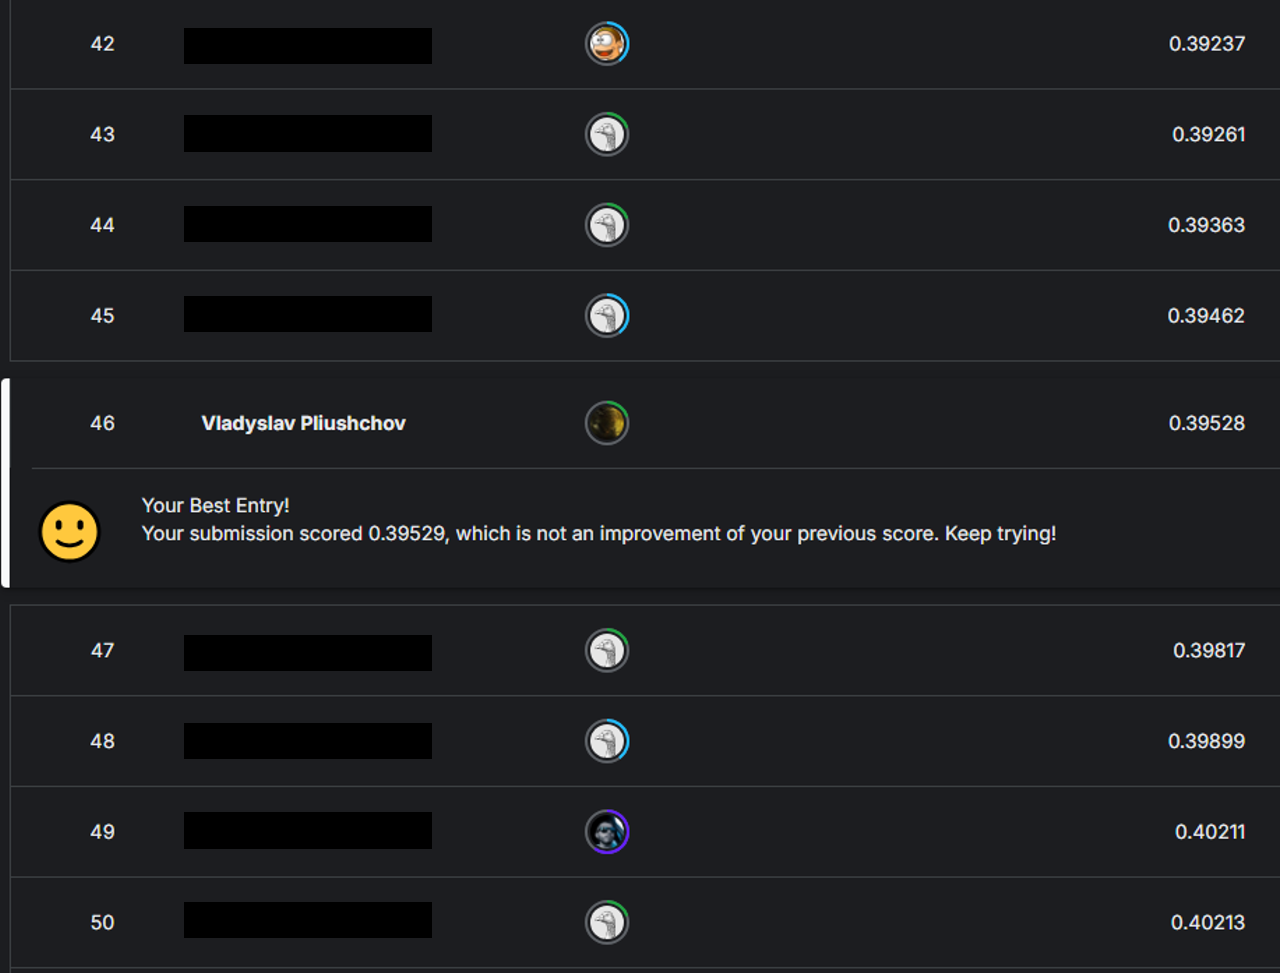
</div>